In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

## Distribution of a vanilla product at a future time, following several methodologies 
* Closed formula
* Malliavin estimator
* Malliavin estimator with localization

In [2]:
# simulation from 0 to T of a geometric brownian
nbsimul = 200000
nbpas = 100
mu=0.1
sigma=0.1
S0 = 100
K=99.99
T=1
pas = T/nbpas

X = np.random.default_rng().normal(0, 1, size=(nbsimul,nbpas))*np.sqrt(pas)
W = np.concatenate((np.zeros((nbsimul,1)), np.cumsum(X,axis=1)), axis=1)

rlog = (mu-sigma**2/2)*pas + sigma*X
cumrlog = np.concatenate((np.zeros((nbsimul,1)), np.cumsum(rlog,axis=1)), axis=1)
S=S0*np.exp(cumrlog)

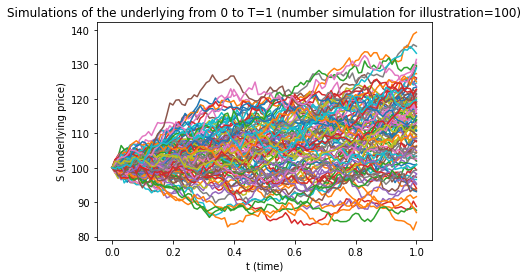

In [3]:
# show an extract of the underlyings
nbsim_illust=100
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(nbpas+1)*pas, S[0:nbsim_illust,:].T);
ax.set_xlabel('t (time)')
ax.set_ylabel('S (underlying price)')
ax.set_title("Simulations of the underlying from 0 to T="+str(T)+" (number simulation for illustration="+str(nbsim_illust)+")");

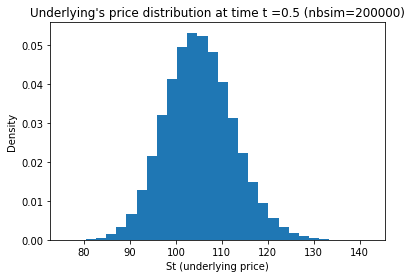

In [4]:
# Underlying's distribution at time t (here t=T/2)
t = T/2
michemin = int(nbpas*t/T)
count, bins, ignored = plt.hist(S[:,michemin], 30, density=True)
plt.xlabel('St (underlying price)')
plt.ylabel('Density')
plt.title("Underlying's price distribution at time t ="+str(t)+" (nbsim="+str(nbsimul)+")");

In [5]:
# vanilla call option pricer
def vanille(S, K, r, sigma, T):
    from scipy.stats import norm
    d1 = (np.log (S/K) + (r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    C = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return C

In [6]:
# Vanilla price at (closed formula)
C0 = vanille(S0, K, mu, sigma, T)
print("C0=",C0)

C0= 10.315652669063113


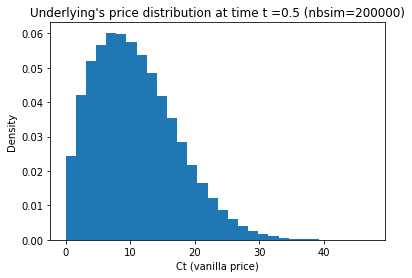

In [7]:
# distribution of the vanilla at price t (closed formula)
C=np.zeros(nbsimul)
C = vanille(S[:,michemin], K, mu, sigma, T-t)  
count, bins, ignored = plt.hist(C, 30, density=True)
plt.xlabel('Ct (vanilla price)')
plt.ylabel('Density')
plt.title("Underlying's price distribution at time t ="+str(t)+" (nbsim="+str(nbsimul)+")");

In [8]:
# function of localization (Laplace law)
def laplace_df(x,l):
    f = 1/(2*l) *np.exp(-abs(x)/l)
    return f

def laplace_cdf(x,l):
    F = 0.5* (1+np.sign(x)*(1-np.exp(-np.abs(x)/l)))
    return F

In [9]:
# intermediate variables
ST = S[:,nbpas]
St = S[:,michemin]
WT = W[:,nbpas]
Wt = W[:,michemin]

In [10]:
# distribution of the vanilla price at time 0 (Monte-Carlo)
PO=np.zeros(nbsimul)
PO= np.maximum(ST-K,0.0) ## correction
POt = np.maximum(St-K,0.0) ## correction
C0m = np.exp(-mu*T)*np.mean(PO)
print(C0m)

10.345418418986457


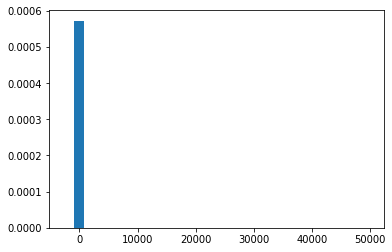

In [11]:
# distribution of the vanilla price at time t (Malliavin)
c=0
Cm=np.zeros(nbsimul)
Cml=np.zeros(nbsimul)
sum1 = 0.
sum2 = 0.
DeltaW = (T*Wt - t*WT)+(T-t)*t*sigma
coef = ((T*Wt - t*WT)/(T-t) + sigma*t)/St
actu = np.exp(-mu*(T-t))
h = mu-sigma**2/2
den = PO**2
t2 =  DeltaW/(t*(T-t)*sigma*St)
num = den*( t2 )**2
l1 = (1/S0) * np.exp(-(h+sigma**2)*t) * np.sqrt((T+sigma**2*t*(T-t))/(sigma**2*t*(T-t)))
lf = np.sqrt(np.mean(num)/np.mean(den))
for i in range(nbsimul):
    #print(St)
    #print(np.heaviside(St-St[i],0.5))
    pp = (np.heaviside(St-St[i],0.001)+c)*coef
    num = PO*pp
    mpp = np.mean(pp)
    mnum = np.mean(num)
    pp_loc_1 = laplace_df(St-St[i],l1) + (np.heaviside(St-St[i],0.001)-laplace_cdf(St-St[i],l1))*t2
    pp_loc_f = laplace_df(St-St[i],lf) + (np.heaviside(St-St[i],0.001)-laplace_cdf(St-St[i],lf))*t2
    num_loc_f = PO*pp_loc_f
    mpp_loc = np.mean(pp_loc_1)
    mnum_loc = np.mean(num_loc_f)
    Cm[i]=actu*mnum/mpp
    Cml[i]=actu*mnum_loc/mpp_loc
count, bins, ignored = plt.hist(Cm, 30, density=True)

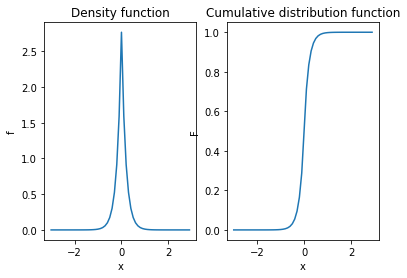

In [12]:
# Laplace's distribution for the localization function
fig =plt.figure()
ax = fig.add_subplot(1,2,1)
x=np.arange(-3,3,0.1)
ax.plot(x, laplace_df(x,lf))
ax.set_xlabel('x')
ax.set_ylabel('f')
ax.set_title("Density function");
ay = fig.add_subplot(1,2,2)
ay.plot(x, laplace_cdf(x,lf));
ay.set_xlabel('x')
ay.set_ylabel('F')
ay.set_title("Cumulative distribution function");

## Study of the accuracy of Malliavin estimator

(0.0, 50.0)

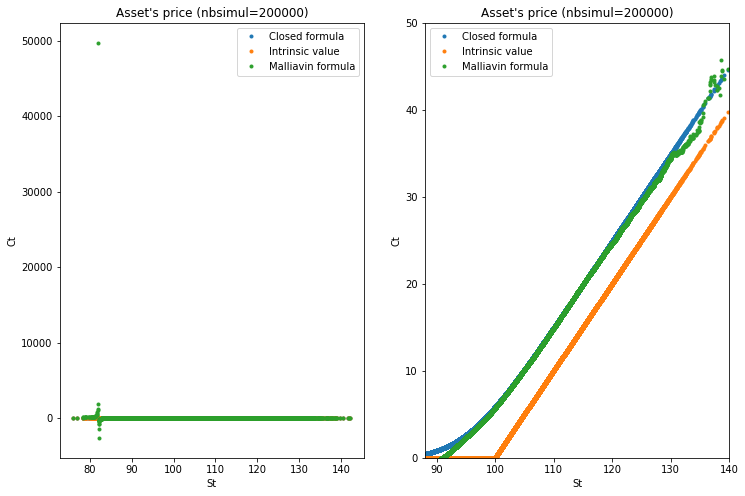

In [13]:
# Comparison between Malliavin method and real values (closed formula)
CC = np.concatenate((C[:, None], POt[:, None], Cm[:, None]),axis=1)
fig =plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,2,1)
ax.plot(St, CC,'.', label=('Closed formula', 'Intrinsic value',"Malliavin formula"))
ax.legend(loc='best')
ax.set_xlabel('St')
ax.set_ylabel('Ct')
ax.set_title("Asset's price (nbsimul="+str(nbsimul)+")");
ay = fig.add_subplot(1,2,2)
ay.plot(St, CC,'.', label=('Closed formula', 'Intrinsic value',"Malliavin formula"))
ay.legend(loc='best')
ay.set_xlabel('St')
ay.set_ylabel('Ct')
ay.set_title("Asset's price (nbsimul="+str(nbsimul)+")");
ay.set_xlim([88,140])
ay.set_ylim([0,50])


(0.0, 50.0)

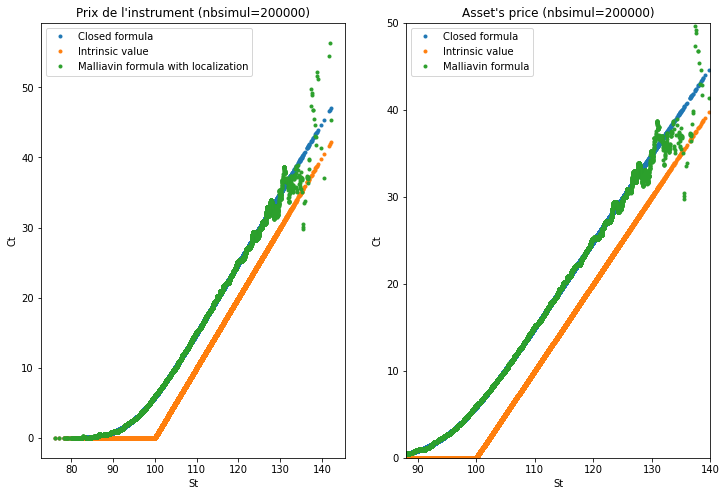

In [37]:
# Comparison between Malliavin method (with localization) and real values (closed formula)
CC = np.concatenate((C[:, None], POt[:, None], Cml[:, None]),axis=1)
fig =plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,2,1)
ax.plot(St, CC,'.', label=('Closed formula', 'Intrinsic value', "Malliavin formula with localization"))
ax.legend(loc='best')
ax.set_xlabel('St')
ax.set_ylabel('Ct')
ax.set_title("Prix de l'instrument (nbsimul="+str(nbsimul)+")");
ay = fig.add_subplot(1,2,2)
ay.plot(St, CC,'.', label=('Closed formula', 'Intrinsic value',"Malliavin formula"))
ay.legend(loc='best')
ay.set_xlabel('St')
ay.set_ylabel('Ct')
ay.set_title("Asset's price (nbsimul="+str(nbsimul)+")");
ay.set_xlim([88,140])
ay.set_ylim([0,50])

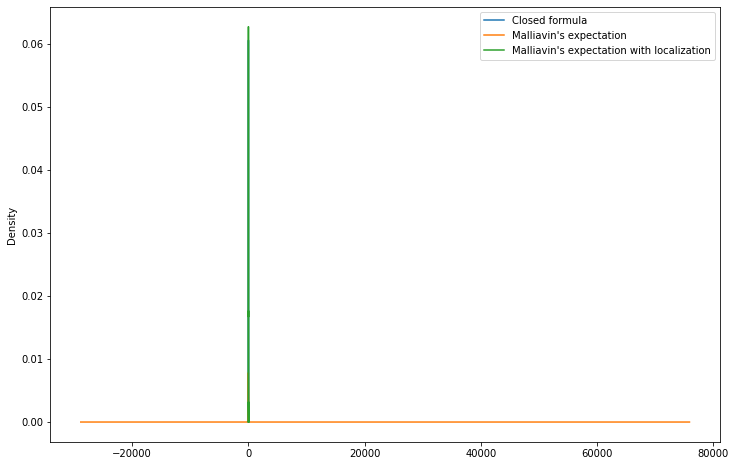

In [26]:
# Comparison of the 3 densities : closed formula (C)
pCm = pd.DataFrame(Cm, columns=["Malliavin's expectation"])
pC = pd.DataFrame(C, columns=['Closed formula'])
pCml = pd.DataFrame(Cml, columns=["Malliavin's expectation with localization"])
multiC = pd.concat([pC, pCm, pCml])
#multiC = multiC.mask(multiC > 0)
#multiC = multiC.mask(multiC < 100)
multiC.plot.density(figsize=(12,8));

In [27]:
multiC = pd.concat([pC, pCm, pCml])
multiC

,Closed formula,Malliavin's expectation,Malliavin's expectation with localization
0,12.443800,NaN,NaN
1,17.257078,NaN,NaN
2,3.537378,NaN,NaN
3,0.337947,NaN,NaN
4,4.798991,NaN,NaN
...,...,...,...
199995,NaN,NaN,8.547055
199996,NaN,NaN,13.528969
199997,NaN,NaN,11.044883
199998,NaN,NaN,7.858186


In [31]:
max(C)

47.10851412039884

In [32]:
max(Cm)

49740.56376407196

In [33]:
max(Cml)

56.362184849899116

In [34]:
min(C)

0.0012402589429328092

In [35]:
min(Cm)

-2658.2458643754494

In [36]:
min(Cml)

1.016404589108967e-15